In [1]:
import os
import uuid
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import ants


from tools.config import Config, read_conf

In [2]:
class MRTDataset(Dataset):
    def __init__(self, config, health_flg, transform=None):
        self.config = config
        self.transform = transform
        self.person_dict = {}
        self.person_list = []
        self.health_flg = health_flg
        self._init_dataset()

    def _init_dataset(self):
        max_batch = self.config.train.max_batch if self.health_flg else self.config.test.max_batch
        for address, dirs, files in os.walk(os.path.join(
                self.config.train_path if self.health_flg else self.config.test_path,
                self.config.train_local if self.health_flg else self.config.test_local
        )):
            for file in files:
                if file.endswith(('.nii.gz', '_brain.mha')):
                    person = Person(os.path.join(address, file))
                    if not self.health_flg:
                        person.set_tumor()
                    if (not self.config.slice) or (
                            isinstance(self.config.slice, int) and self.config.slice >= person.num) or (
                            isinstance(self.config.slice, list) and (len(self.config.slice) == 2) and (
                            self.config.slice[0] <= person.num < self.config.slice[1])):
                        self.person_dict[person.uuid] = person
                        self.person_list.append(person)
                if len(self.person_list) >= max_batch:
                    break
            if len(self.person_list) >= max_batch:
                break

    def __str__(self):
        ans = ''
        for person in list(self.person_dict.values()):
            ans += f'{person.__repr__()}\n'
        return ans[:-1] if ans else ''

    def __repr__(self):
        ans = ''
        for person in list(self.person_dict.values()):
            ans += f'{person}\n'
        return ans[:-1] if ans else ''

    def __len__(self):
        return len(self.person_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.get_person(idx)(self.transform)

    def dataloader(self, shuffle=True):
        return DataLoader(self,
                          batch_size=self.config.train.batch_size if self.health_flg else self.config.test.batch_size,
                          shuffle=shuffle)

    def get_img_shape(self):
        return list(self.get_random()(self.transform).shape) if len(self.person_list) != 0 else 0

    def get_random(self):
        return np.random.choice(self.person_list, 1)[0]

    def get_person(self, idx):
        if isinstance(idx, str):
            return self.person_dict[idx]
        elif isinstance(idx, int):
            return self.person_list[idx]
        else:
            raise TypeError(f'Неверный тип. Хотел: int или str, а получил {idx.__type__}')


class Person:
    def __init__(self, path):
        self.uuid = str(uuid.uuid4())
        self.path = path
        self.tumor = None
        self.name = path.split('/')[-1].split('.')[0]
        if self.path.endswith('.nii.gz'):
            self.num = int(self.name.split('_')[-1])
        if self.path.endswith('.mha'):
            self.num = int(self.name.split('_')[0][3:])

    def __str__(self):
        return f"{self.uuid}: {self.path}"

    def __repr__(self):
        return f"{self.uuid[:-6]}: {self.name}"

    def get_tumor(self, transform=None):
        if self.tumor:
            img = ants.image_read(self.tumor)
            return transform(img) if transform else img
        else:
            return None

    def set_tumor(self):
        self.tumor = f'{self.path[:-10]}_tumor.mha'

    def plot(self):
        self.get_brain().plot()

    def get_brain(self, np_flg=False):
        img = ants.image_read(self.path)
        return img.numpy() if np_flg else img

    def __call__(self, transform=None):
        return transform(self.get_brain()) if transform else self.get_brain(np_flg=True).astype(np.float32)

In [3]:
def generator(config, train_flg):
    trf = []
    if config.transforms.norm:
        trf.append(ants.iMath_normalize)
    if config.transforms.resize:
        def resize(obj, img_size=config.transforms.img_size):
            return obj.resample_image((img_size, img_size, obj.shape[2]), 1, 0)
        trf.append(resize)
    trf.append(lambda x: np.flip(x.numpy(), 1).astype(np.float32) if train_flg else x.numpy().astype(np.float32))
    if config.transforms.to_tensor:
        trf.append(transforms.ToTensor())

    dataset = MRTDataset(config=config, health_flg=train_flg, transform=transforms.Compose(trf))

    return dataset

In [4]:
class AAE():
    def __init__(self, config, train_flg=True):
        self.config = config.train if train_flg else config.test
        self.output = config.result
        self.img_shape = config.transforms.img_shape
        self.img_shape[0] *= self.config.batch_size
        self.cuda = config.cuda and torch.cuda.is_available()
        print(f'\033[3{2 if self.cuda else 1}m[Cuda: {self.cuda}]\033[0m')
        self.Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor
        self.config += {'Tensor': self.Tensor}

        # Use binary cross-entropy loss
        self.adversarial_loss = torch.nn.BCELoss()
        self.pixelwise_loss = torch.nn.L1Loss()

        # Initialize generator and discriminator
        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config, self.img_shape)
        self.discriminator = Discriminator(self.config)

        if self.cuda:
            self.encoder.cuda()
            self.decoder.cuda()
            self.discriminator.cuda()
            self.adversarial_loss.cuda()
            self.pixelwise_loss.cuda()

    def __repr__(self):
        return f'cuda: {self.cuda}\n' + \
               f'config: {self.config}'

    def __str__(self):
        return f'{self.__repr__()}\n' + \
               f'{self.encoder}\n{self.decoder}\n{self.discriminator}'

    def sample_image(self, n_row=5, batches_done='AAE_image'):
        z = Variable(self.Tensor(np.random.normal(0, 1, (n_row**2, self.config.latent_dim))))
        gen_imgs = self.decoder(z)
        save_image(gen_imgs.unsqueeze(1), os.path.join(self.output, f"{batches_done}.png"), nrow=n_row, normalize=True)

    def train(self, dataset):
        # Optimizers
        self.optimizer_G = torch.optim.Adam(
            itertools.chain(
                self.encoder.parameters(),
                self.decoder.parameters()
            ),
            lr=self.config.lr,
            betas=(self.config.b1, self.config.b2)
        )
        self.optimizer_D = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=self.config.lr,
            betas=(self.config.b1, self.config.b2))

        # tensorboard callback
        self.writer = SummaryWriter(os.path.join(self.output, 'log'))

        self.running_loss_g = 0
        self.running_loss_d = 0

        dataloader = dataset.dataloader()
        for epoch in tqdm(range(self.config.n_epochs), total=self.config.n_epochs, desc='Epoch', leave=True):
            for batch in tqdm(dataloader, total=len(dataloader), desc='Bath'):

                imgs = batch.reshape(-1, self.img_shape[1], self.img_shape[2])
                # imgs = batch.permute(0, 3, 1, 2).reshape(-1, self.img_shape[0], self.img_shape[1])
                # Adversarial ground truths
                valid = Variable(self.Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
                fake = Variable(self.Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

                # Configure input
                real_imgs = Variable(imgs.type(self.Tensor))

                # -----------------
                #  Train Generator
                # -----------------

                self.optimizer_G.zero_grad()

                encoded_imgs = self.encoder(real_imgs)
                decoded_imgs = self.decoder(encoded_imgs)

                # Loss measures generator's ability to fool the discriminator
                g_loss = \
                    0.01 * self.adversarial_loss(self.discriminator(encoded_imgs), valid) + \
                    0.99 * self.pixelwise_loss(decoded_imgs, real_imgs)
                g_loss.backward()
                self.optimizer_G.step()
                self.running_loss_g += g_loss.item()

                # ---------------------
                #  Train Discriminator
                # ---------------------

                self.optimizer_D.zero_grad()

                # Sample noise as discriminator ground truth
                z = Variable(self.Tensor(np.random.normal(0, 1, (imgs.shape[0], self.config.latent_dim))))

                # Measure discriminator's ability to classify real from generated samples
                real_loss = self.adversarial_loss(self.discriminator(z), valid)
                fake_loss = self.adversarial_loss(self.discriminator(encoded_imgs.detach()), fake)
                d_loss = 0.5 * (real_loss + fake_loss)

                d_loss.backward()
                self.optimizer_D.step()
                self.running_loss_d += d_loss.item()
            self.tensorboard_callback(epoch, len(dataloader))
        self.writer.close()

    def test(self, dataset, acc=0.3, pre=0.8, idx=None):
        ans = [0, 0, None, None]
        for idx in tqdm(range(len(dataset))):
            test_person = dataset.get_person(idx)
            test_tumor_tensor = test_person.get_tumor(transform=dataset.transform).cpu()
            test_brain = test_person.get_brain()
            test_brain_tensor = Variable(test_person(dataset.transform).type(self.Tensor))
            decoded_img = self.decoder(self.encoder(test_brain_tensor)).data.cpu()
            mask = ants.get_mask(test_brain)
            mask = ants.iMath(mask,'ME',2)
            decoded_img *= dataset.transform(mask)
            decoded_img = torch.clamp(decoded_img, 0, 1)
            restore_tumor = abs(decoded_img - test_brain_tensor.data.cpu())
            restore_tumor[restore_tumor < acc] = 0

            acc_loss = self.pixelwise_loss.cpu()(decoded_img, test_brain_tensor.data.cpu()).item()
            ttn = (test_tumor_tensor != 0).sum().item()
            rtn = (restore_tumor != 0).sum().item()
            tn = (restore_tumor*test_tumor_tensor != 0).sum().item()
            pre_loss = 2*tn/(ttn+rtn) if ttn+rtn else 1
            
            if pre_loss > ans [0]:
                ans[0] = pre_loss
                ans[1] = acc_loss
                ans[2] = restore_tumor
                ans[3] = test_tumor_tensor
        return ans

    def test_show_jupyter(self):
        
    
    def test_show(self, dataset, acc=0.3, pre=0.8, idx=None):
        test_person = dataset.get_person(idx) if idx else dataset.get_random()
        test_tumor_tensor = test_person.get_tumor(transform=dataset.transform).cpu()
        test_brain = test_person.get_brain()
        test_brain_tensor = Variable(test_person(dataset.transform).type(self.Tensor))
#         test_brain = test_person.get_brain(np_flg=False)
        decoded_img = self.decoder(self.encoder(test_brain_tensor)).data.cpu()
        mask = ants.get_mask(test_brain)
        mask = ants.iMath(mask,'ME',2)# just to speed things up
        # cropped = ants.crop_image(another_brain, mask, 1)
        decoded_img *= dataset.transform(mask)
        decoded_img = torch.clamp(decoded_img, 0, 1)
#         print(decoded_img.cpu().numpy().shape, test_brain.numpy().shape)
        return test_brain, decoded_img
#         restore_tumor = abs(decoded_img - test_brain_tensor.data.cpu())
#         restore_tumor[restore_tumor < acc] = 0
        
#         acc_loss = self.pixelwise_loss.cpu()(decoded_img, test_brain_tensor.data.cpu()).item()
#         ttn = (test_tumor_tensor != 0).sum().item()
#         rtn = (restore_tumor != 0).sum().item()
#         tn = (restore_tumor*test_tumor_tensor != 0).sum().item()
#         pre_loss = 2*tn/(ttn+rtn) if ttn+rtn else 1
#         print(acc_loss, pre_loss)
#         return restore_tumor, test_tumor_tensor
#         decoded_img_np = decoded_img.cpu().detach().permute(1, 2, 0).numpy()

    def _test_show(save):

    def save(self, save_path):
        torch.save(self.encoder.state_dict(), os.path.join(save_path, 'encoder'))
        torch.save(self.decoder.state_dict(), os.path.join(save_path, 'decoder'))
        torch.save(self.discriminator.state_dict(), os.path.join(save_path, 'discriminator'))

    def load(self, load_path):
        self.encoder.load_state_dict(torch.load(os.path.join(load_path, 'encoder')))
        self.decoder.load_state_dict(torch.load(os.path.join(load_path, 'decoder')))
        self.discriminator.load_state_dict(torch.load(os.path.join(load_path, 'discriminator')))

    def tensorboard_callback(self, i, dlen):
        self.writer.add_scalar('Loss/d_loss', self.running_loss_d / dlen, i)
        self.writer.add_scalar('Loss/g_loss', self.running_loss_g / dlen, i)


class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.config = config
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )
        self.mu = nn.Linear(512, self.config.latent_dim)
        self.logvar = nn.Linear(512, self.config.latent_dim)

    def forward(self, img):
        x = self.model(img.unsqueeze(1))
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.reparameterization(mu, logvar)
        return z

    def reparameterization(self, mu, logvar):
        std = torch.exp(logvar / 2)
        sampled_z = Variable(self.config.Tensor(np.random.normal(0, 1, (mu.size(0), self.config.latent_dim))))
        z = sampled_z * std + mu
        return z


class Decoder(nn.Module):
    def __init__(self, config, img_shape):
        super(Decoder, self).__init__()
        self.config = config
        self.img_shape = img_shape[1:]
        
        self.model_prep = nn.Sequential(
            nn.Linear(self.config.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.model = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias = False),
            nn.Tanh()
        )        

    def forward(self, z):
        img_conv = self.model_prep(z).unsqueeze(2).unsqueeze(3)
        img = self.model(img_conv).view(-1, *self.img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self, config):
        super(Discriminator, self).__init__()
        self.config = config

        self.model = nn.Sequential(
            nn.Linear(self.config.latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [5]:
%%bash
ls /root/weights
# rm /root/weights/*

decoder
discriminator
encoder


In [6]:
%%bash
ls /root/result/
# rm /root/result/AAE_image.png
# rm /root/result/log/*

AAE_image.png
log


In [7]:
def train(config, save_path):
    config.train.max_batch = 100
    config.train.n_epochs = 150
    dataset = generator(config, train_flg=True)
    config.transforms += {'img_shape': dataset.get_img_shape()}
    model = AAE(config)
    model.train(dataset)
    model.save(save_path)
    model.sample_image()

In [8]:
def test(config, load_path):
    dataset = generator(config, train_flg=False)
    config.transforms += {'img_shape': dataset.get_img_shape()}
    model = AAE(config, train_flg=False)
    model.load(load_path)
    return model.test(dataset)


def test_show(config, load_path):
    dataset = generator(config, train_flg=False)
    config.transforms += {'img_shape': dataset.get_img_shape()}
    model = AAE(config, train_flg=False)
    model.load(load_path)
    return model.test_show(dataset)
#     restore_tumor, test_tumor_tensor = model.test_show(dataset)

In [12]:
config = read_conf(f'/root/cAAE/config/config_test.json')
save_path = '/root/weights'
train(config, save_path)



Epoch:   0%|          | 0/150 [00:00<?, ?it/s]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]

[Cuda: True]





Bath:   2%|▏         | 1/50 [00:03<03:02,  3.73s/it]


Bath:   4%|▍         | 2/50 [00:07<02:54,  3.64s/it]


Bath:   6%|▌         | 3/50 [00:10<02:52,  3.66s/it]


Bath:   8%|▊         | 4/50 [00:14<02:47,  3.65s/it]


Bath:  10%|█         | 5/50 [00:18<02:42,  3.62s/it]


Bath:  12%|█▏        | 6/50 [00:21<02:38,  3.61s/it]


Bath:  14%|█▍        | 7/50 [00:25<02:35,  3.62s/it]


Bath:  16%|█▌        | 8/50 [00:29<02:34,  3.67s/it]


Bath:  18%|█▊        | 9/50 [00:32<02:30,  3.66s/it]


Bath:  20%|██        | 10/50 [00:36<02:26,  3.67s/it]


Bath:  22%|██▏       | 11/50 [00:40<02:23,  3.69s/it]


Bath:  24%|██▍       | 12/50 [00:43<02:18,  3.64s/it]


Bath:  26%|██▌       | 13/50 [00:47<02:15,  3.67s/it]


Bath:  28%|██▊       | 14/50 [00:50<02:09,  3.61s/it]


Bath:  30%|███       | 15/50 [00:54<02:04,  3.55s/it]


Bath:  32%|███▏      | 16/50 [00:57<02:02,  3.60s/it]


Bath:  34%|███▍      | 17/50 [01:01<01:58,  3.58s/it]


Bath:  36%|███▌      | 18/50 [01:04<01:53,  3.54s/it]


Bath:  90%|█████████ | 45/50 [02:45<00:18,  3.62s/it]


Bath:  92%|█████████▏| 46/50 [02:48<00:14,  3.59s/it]


Bath:  94%|█████████▍| 47/50 [02:52<00:10,  3.62s/it]


Bath:  96%|█████████▌| 48/50 [02:55<00:07,  3.59s/it]


Bath:  98%|█████████▊| 49/50 [02:59<00:03,  3.56s/it]


Bath: 100%|██████████| 50/50 [03:02<00:00,  3.57s/it]

Epoch:   3%|▎         | 5/150 [15:01<7:16:58, 180.82s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<02:47,  3.42s/it]


Bath:   4%|▍         | 2/50 [00:06<02:45,  3.46s/it]


Bath:   6%|▌         | 3/50 [00:10<02:44,  3.49s/it]


Bath:   8%|▊         | 4/50 [00:14<02:42,  3.53s/it]


Bath:  10%|█         | 5/50 [00:17<02:39,  3.54s/it]


Bath:  12%|█▏        | 6/50 [00:21<02:34,  3.51s/it]


Bath:  14%|█▍        | 7/50 [00:24<02:30,  3.50s/it]


Bath:  16%|█▌        | 8/50 [00:28<02:28,  3.53s/it]


Bath:  18%|█▊        | 9/50 [00:31<02:24,  3.51s/it]


Bath:  20%|██        | 10/50 [00:35<02:21,  3.55s/it]


Bath:  

Bath:  74%|███████▍  | 37/50 [02:15<00:47,  3.63s/it]


Bath:  76%|███████▌  | 38/50 [02:19<00:43,  3.66s/it]


Bath:  78%|███████▊  | 39/50 [02:22<00:40,  3.70s/it]


Bath:  80%|████████  | 40/50 [02:26<00:37,  3.72s/it]


Bath:  82%|████████▏ | 41/50 [02:30<00:33,  3.70s/it]


Bath:  84%|████████▍ | 42/50 [02:34<00:29,  3.72s/it]


Bath:  86%|████████▌ | 43/50 [02:37<00:26,  3.72s/it]


Bath:  88%|████████▊ | 44/50 [02:41<00:22,  3.69s/it]


Bath:  90%|█████████ | 45/50 [02:44<00:18,  3.63s/it]


Bath:  92%|█████████▏| 46/50 [02:48<00:14,  3.61s/it]


Bath:  94%|█████████▍| 47/50 [02:52<00:10,  3.59s/it]


Bath:  96%|█████████▌| 48/50 [02:55<00:07,  3.64s/it]


Bath:  98%|█████████▊| 49/50 [02:59<00:03,  3.58s/it]


Bath: 100%|██████████| 50/50 [03:02<00:00,  3.53s/it]

Epoch:   7%|▋         | 10/150 [30:19<7:06:52, 182.95s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<02:52,  3.52s/it]


Bath:   4%|▍         | 2/50 [00:07<02:51,  3.57s/it]



Bath:  58%|█████▊    | 29/50 [01:45<01:16,  3.63s/it]


Bath:  60%|██████    | 30/50 [01:49<01:13,  3.67s/it]


Bath:  62%|██████▏   | 31/50 [01:52<01:09,  3.64s/it]


Bath:  64%|██████▍   | 32/50 [01:56<01:04,  3.58s/it]


Bath:  66%|██████▌   | 33/50 [01:59<01:00,  3.54s/it]


Bath:  68%|██████▊   | 34/50 [02:02<00:56,  3.52s/it]


Bath:  70%|███████   | 35/50 [02:06<00:52,  3.49s/it]


Bath:  72%|███████▏  | 36/50 [02:09<00:48,  3.47s/it]


Bath:  74%|███████▍  | 37/50 [02:13<00:45,  3.47s/it]


Bath:  76%|███████▌  | 38/50 [02:16<00:42,  3.54s/it]


Bath:  78%|███████▊  | 39/50 [02:20<00:39,  3.55s/it]


Bath:  80%|████████  | 40/50 [02:24<00:35,  3.52s/it]


Bath:  82%|████████▏ | 41/50 [02:27<00:31,  3.50s/it]


Bath:  84%|████████▍ | 42/50 [02:31<00:28,  3.52s/it]


Bath:  86%|████████▌ | 43/50 [02:34<00:24,  3.56s/it]


Bath:  88%|████████▊ | 44/50 [02:38<00:21,  3.57s/it]


Bath:  90%|█████████ | 45/50 [02:41<00:17,  3.53s/it]


Bath:  92%|█████████▏| 46/50 [02:45<00:14,  3.57

Bath:  42%|████▏     | 21/50 [01:17<01:46,  3.66s/it]


Bath:  44%|████▍     | 22/50 [01:21<01:43,  3.69s/it]


Bath:  46%|████▌     | 23/50 [01:24<01:39,  3.67s/it]


Bath:  48%|████▊     | 24/50 [01:28<01:36,  3.70s/it]


Bath:  50%|█████     | 25/50 [01:32<01:32,  3.72s/it]


Bath:  52%|█████▏    | 26/50 [01:35<01:29,  3.72s/it]


Bath:  54%|█████▍    | 27/50 [01:39<01:25,  3.73s/it]


Bath:  56%|█████▌    | 28/50 [01:43<01:22,  3.74s/it]


Bath:  58%|█████▊    | 29/50 [01:47<01:18,  3.75s/it]


Bath:  60%|██████    | 30/50 [01:51<01:15,  3.75s/it]


Bath:  62%|██████▏   | 31/50 [01:54<01:11,  3.76s/it]


Bath:  64%|██████▍   | 32/50 [01:58<01:07,  3.76s/it]


Bath:  66%|██████▌   | 33/50 [02:02<01:03,  3.76s/it]


Bath:  68%|██████▊   | 34/50 [02:06<01:00,  3.76s/it]


Bath:  70%|███████   | 35/50 [02:09<00:56,  3.76s/it]


Bath:  72%|███████▏  | 36/50 [02:13<00:52,  3.76s/it]


Bath:  74%|███████▍  | 37/50 [02:17<00:48,  3.76s/it]


Bath:  76%|███████▌  | 38/50 [02:21<00:45,  3.75

Bath:  26%|██▌       | 13/50 [00:46<02:14,  3.63s/it]


Bath:  28%|██▊       | 14/50 [00:50<02:10,  3.63s/it]


Bath:  30%|███       | 15/50 [00:54<02:08,  3.68s/it]


Bath:  32%|███▏      | 16/50 [00:57<02:06,  3.71s/it]


Bath:  34%|███▍      | 17/50 [01:01<02:03,  3.74s/it]


Bath:  36%|███▌      | 18/50 [01:05<01:58,  3.72s/it]


Bath:  38%|███▊      | 19/50 [01:09<01:54,  3.70s/it]


Bath:  40%|████      | 20/50 [01:12<01:51,  3.72s/it]


Bath:  42%|████▏     | 21/50 [01:16<01:48,  3.75s/it]


Bath:  44%|████▍     | 22/50 [01:20<01:45,  3.78s/it]


Bath:  46%|████▌     | 23/50 [01:24<01:39,  3.69s/it]


Bath:  48%|████▊     | 24/50 [01:27<01:34,  3.62s/it]


Bath:  50%|█████     | 25/50 [01:30<01:29,  3.56s/it]


Bath:  52%|█████▏    | 26/50 [01:34<01:25,  3.54s/it]


Bath:  54%|█████▍    | 27/50 [01:38<01:23,  3.62s/it]


Bath:  56%|█████▌    | 28/50 [01:41<01:20,  3.66s/it]


Bath:  58%|█████▊    | 29/50 [01:45<01:17,  3.70s/it]


Bath:  60%|██████    | 30/50 [01:49<01:14,  3.72

Bath:  10%|█         | 5/50 [00:18<02:49,  3.78s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:46,  3.77s/it]


Bath:  14%|█▍        | 7/50 [00:26<02:42,  3.77s/it]


Bath:  16%|█▌        | 8/50 [00:30<02:38,  3.77s/it]


Bath:  18%|█▊        | 9/50 [00:33<02:34,  3.76s/it]


Bath:  20%|██        | 10/50 [00:37<02:26,  3.67s/it]


Bath:  22%|██▏       | 11/50 [00:40<02:20,  3.61s/it]


Bath:  24%|██▍       | 12/50 [00:44<02:19,  3.66s/it]


Bath:  26%|██▌       | 13/50 [00:48<02:16,  3.70s/it]


Bath:  28%|██▊       | 14/50 [00:52<02:14,  3.73s/it]


Bath:  30%|███       | 15/50 [00:55<02:10,  3.72s/it]


Bath:  32%|███▏      | 16/50 [00:59<02:06,  3.73s/it]


Bath:  34%|███▍      | 17/50 [01:03<02:03,  3.74s/it]


Bath:  36%|███▌      | 18/50 [01:07<02:00,  3.75s/it]


Bath:  38%|███▊      | 19/50 [01:10<01:55,  3.74s/it]


Bath:  40%|████      | 20/50 [01:14<01:50,  3.68s/it]


Bath:  42%|████▏     | 21/50 [01:18<01:45,  3.64s/it]


Bath:  44%|████▍     | 22/50 [01:21<01:43,  3.68s/it]

Bath:  98%|█████████▊| 49/50 [02:58<00:03,  3.61s/it]


Bath: 100%|██████████| 50/50 [03:02<00:00,  3.66s/it]

Epoch:  23%|██▎       | 34/150 [1:43:33<5:54:45, 183.50s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<03:06,  3.80s/it]


Bath:   4%|▍         | 2/50 [00:07<03:02,  3.79s/it]


Bath:   6%|▌         | 3/50 [00:11<02:58,  3.79s/it]


Bath:   8%|▊         | 4/50 [00:15<02:54,  3.79s/it]


Bath:  10%|█         | 5/50 [00:18<02:50,  3.79s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:46,  3.79s/it]


Bath:  14%|█▍        | 7/50 [00:26<02:42,  3.79s/it]


Bath:  16%|█▌        | 8/50 [00:30<02:38,  3.78s/it]


Bath:  18%|█▊        | 9/50 [00:34<02:34,  3.77s/it]


Bath:  20%|██        | 10/50 [00:37<02:31,  3.78s/it]


Bath:  22%|██▏       | 11/50 [00:41<02:26,  3.75s/it]


Bath:  24%|██▍       | 12/50 [00:45<02:22,  3.75s/it]


Bath:  26%|██▌       | 13/50 [00:48<02:17,  3.71s/it]


Bath:  28%|██▊       | 14/50 [00:52<02:12,  3.69s/it]


Bath

Bath:  82%|████████▏ | 41/50 [02:30<00:33,  3.68s/it]


Bath:  84%|████████▍ | 42/50 [02:34<00:29,  3.72s/it]


Bath:  86%|████████▌ | 43/50 [02:37<00:25,  3.69s/it]


Bath:  88%|████████▊ | 44/50 [02:41<00:22,  3.71s/it]


Bath:  90%|█████████ | 45/50 [02:45<00:18,  3.69s/it]


Bath:  92%|█████████▏| 46/50 [02:48<00:14,  3.69s/it]


Bath:  94%|█████████▍| 47/50 [02:52<00:10,  3.65s/it]


Bath:  96%|█████████▌| 48/50 [02:55<00:07,  3.61s/it]


Bath:  98%|█████████▊| 49/50 [02:59<00:03,  3.56s/it]


Bath: 100%|██████████| 50/50 [03:03<00:00,  3.63s/it]

Epoch:  26%|██▌       | 39/150 [1:58:49<5:38:49, 183.15s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<02:55,  3.58s/it]


Bath:   4%|▍         | 2/50 [00:07<02:49,  3.54s/it]


Bath:   6%|▌         | 3/50 [00:10<02:48,  3.59s/it]


Bath:   8%|▊         | 4/50 [00:14<02:43,  3.56s/it]


Bath:  10%|█         | 5/50 [00:17<02:42,  3.61s/it]


Bath:  12%|█▏        | 6/50 [00:21<02:41,  3.67s/it]


B

Bath:  66%|██████▌   | 33/50 [02:01<01:03,  3.71s/it]


Bath:  68%|██████▊   | 34/50 [02:05<00:59,  3.73s/it]


Bath:  70%|███████   | 35/50 [02:09<00:56,  3.75s/it]


Bath:  72%|███████▏  | 36/50 [02:12<00:52,  3.76s/it]


Bath:  74%|███████▍  | 37/50 [02:16<00:49,  3.77s/it]


Bath:  76%|███████▌  | 38/50 [02:20<00:45,  3.78s/it]


Bath:  78%|███████▊  | 39/50 [02:24<00:41,  3.79s/it]


Bath:  80%|████████  | 40/50 [02:28<00:37,  3.79s/it]


Bath:  82%|████████▏ | 41/50 [02:31<00:34,  3.79s/it]


Bath:  84%|████████▍ | 42/50 [02:35<00:30,  3.76s/it]


Bath:  86%|████████▌ | 43/50 [02:39<00:26,  3.77s/it]


Bath:  88%|████████▊ | 44/50 [02:43<00:22,  3.75s/it]


Bath:  90%|█████████ | 45/50 [02:46<00:18,  3.66s/it]


Bath:  92%|█████████▏| 46/50 [02:50<00:14,  3.60s/it]


Bath:  94%|█████████▍| 47/50 [02:53<00:10,  3.56s/it]


Bath:  96%|█████████▌| 48/50 [02:57<00:07,  3.56s/it]


Bath:  98%|█████████▊| 49/50 [03:00<00:03,  3.53s/it]


Bath: 100%|██████████| 50/50 [03:04<00:00,  3.59

Bath:  50%|█████     | 25/50 [01:32<01:30,  3.61s/it]


Bath:  52%|█████▏    | 26/50 [01:35<01:26,  3.61s/it]


Bath:  54%|█████▍    | 27/50 [01:39<01:23,  3.63s/it]


Bath:  56%|█████▌    | 28/50 [01:43<01:20,  3.67s/it]


Bath:  58%|█████▊    | 29/50 [01:47<01:16,  3.67s/it]


Bath:  60%|██████    | 30/50 [01:50<01:13,  3.68s/it]


Bath:  62%|██████▏   | 31/50 [01:54<01:08,  3.61s/it]


Bath:  64%|██████▍   | 32/50 [01:57<01:05,  3.65s/it]


Bath:  66%|██████▌   | 33/50 [02:01<01:02,  3.69s/it]


Bath:  68%|██████▊   | 34/50 [02:05<00:58,  3.68s/it]


Bath:  70%|███████   | 35/50 [02:09<00:55,  3.73s/it]


Bath:  72%|███████▏  | 36/50 [02:13<00:52,  3.75s/it]


Bath:  74%|███████▍  | 37/50 [02:16<00:48,  3.77s/it]


Bath:  76%|███████▌  | 38/50 [02:20<00:45,  3.77s/it]


Bath:  78%|███████▊  | 39/50 [02:24<00:41,  3.78s/it]


Bath:  80%|████████  | 40/50 [02:28<00:37,  3.78s/it]


Bath:  82%|████████▏ | 41/50 [02:32<00:34,  3.78s/it]


Bath:  84%|████████▍ | 42/50 [02:35<00:29,  3.75

Bath:  34%|███▍      | 17/50 [01:01<01:57,  3.55s/it]


Bath:  36%|███▌      | 18/50 [01:04<01:52,  3.53s/it]


Bath:  38%|███▊      | 19/50 [01:08<01:51,  3.60s/it]


Bath:  40%|████      | 20/50 [01:12<01:48,  3.62s/it]


Bath:  42%|████▏     | 21/50 [01:15<01:45,  3.65s/it]


Bath:  44%|████▍     | 22/50 [01:19<01:43,  3.69s/it]


Bath:  46%|████▌     | 23/50 [01:23<01:40,  3.72s/it]


Bath:  48%|████▊     | 24/50 [01:27<01:36,  3.70s/it]


Bath:  50%|█████     | 25/50 [01:30<01:30,  3.64s/it]


Bath:  52%|█████▏    | 26/50 [01:34<01:27,  3.63s/it]


Bath:  54%|█████▍    | 27/50 [01:38<01:24,  3.67s/it]


Bath:  56%|█████▌    | 28/50 [01:41<01:19,  3.61s/it]


Bath:  58%|█████▊    | 29/50 [01:45<01:14,  3.57s/it]


Bath:  60%|██████    | 30/50 [01:48<01:10,  3.55s/it]


Bath:  62%|██████▏   | 31/50 [01:52<01:06,  3.53s/it]


Bath:  64%|██████▍   | 32/50 [01:55<01:03,  3.50s/it]


Bath:  66%|██████▌   | 33/50 [01:58<00:59,  3.50s/it]


Bath:  68%|██████▊   | 34/50 [02:02<00:57,  3.59

Bath:  18%|█▊        | 9/50 [00:32<02:30,  3.66s/it]


Bath:  20%|██        | 10/50 [00:36<02:28,  3.70s/it]


Bath:  22%|██▏       | 11/50 [00:40<02:22,  3.67s/it]


Bath:  24%|██▍       | 12/50 [00:43<02:19,  3.67s/it]


Bath:  26%|██▌       | 13/50 [00:47<02:17,  3.70s/it]


Bath:  28%|██▊       | 14/50 [00:51<02:12,  3.68s/it]


Bath:  30%|███       | 15/50 [00:55<02:10,  3.71s/it]


Bath:  32%|███▏      | 16/50 [00:58<02:07,  3.74s/it]


Bath:  34%|███▍      | 17/50 [01:02<02:02,  3.72s/it]


Bath:  36%|███▌      | 18/50 [01:06<01:56,  3.65s/it]


Bath:  38%|███▊      | 19/50 [01:09<01:51,  3.60s/it]


Bath:  40%|████      | 20/50 [01:13<01:46,  3.56s/it]


Bath:  42%|████▏     | 21/50 [01:16<01:42,  3.55s/it]


Bath:  44%|████▍     | 22/50 [01:20<01:41,  3.61s/it]


Bath:  46%|████▌     | 23/50 [01:23<01:36,  3.57s/it]


Bath:  48%|████▊     | 24/50 [01:27<01:33,  3.58s/it]


Bath:  50%|█████     | 25/50 [01:30<01:28,  3.56s/it]


Bath:  52%|█████▏    | 26/50 [01:34<01:27,  3.63s

Bath:   2%|▏         | 1/50 [00:03<03:05,  3.79s/it]


Bath:   4%|▍         | 2/50 [00:07<03:01,  3.79s/it]


Bath:   6%|▌         | 3/50 [00:11<02:54,  3.72s/it]


Bath:   8%|▊         | 4/50 [00:14<02:52,  3.74s/it]


Bath:  10%|█         | 5/50 [00:18<02:48,  3.75s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:41,  3.68s/it]


Bath:  14%|█▍        | 7/50 [00:25<02:35,  3.62s/it]


Bath:  16%|█▌        | 8/50 [00:29<02:33,  3.65s/it]


Bath:  18%|█▊        | 9/50 [00:33<02:29,  3.65s/it]


Bath:  20%|██        | 10/50 [00:36<02:27,  3.70s/it]


Bath:  22%|██▏       | 11/50 [00:40<02:25,  3.73s/it]


Bath:  24%|██▍       | 12/50 [00:44<02:22,  3.74s/it]


Bath:  26%|██▌       | 13/50 [00:48<02:18,  3.75s/it]


Bath:  28%|██▊       | 14/50 [00:51<02:14,  3.74s/it]


Bath:  30%|███       | 15/50 [00:55<02:11,  3.76s/it]


Bath:  32%|███▏      | 16/50 [00:59<02:05,  3.70s/it]


Bath:  34%|███▍      | 17/50 [01:03<02:03,  3.74s/it]


Bath:  36%|███▌      | 18/50 [01:06<02:00,  3.76s/it]


B

Bath:  90%|█████████ | 45/50 [02:46<00:18,  3.77s/it]


Bath:  92%|█████████▏| 46/50 [02:49<00:14,  3.70s/it]


Bath:  94%|█████████▍| 47/50 [02:53<00:11,  3.71s/it]


Bath:  96%|█████████▌| 48/50 [02:57<00:07,  3.73s/it]


Bath:  98%|█████████▊| 49/50 [03:01<00:03,  3.77s/it]


Bath: 100%|██████████| 50/50 [03:04<00:00,  3.70s/it]

Epoch:  45%|████▌     | 68/150 [3:28:03<4:14:48, 186.44s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<02:51,  3.50s/it]


Bath:   4%|▍         | 2/50 [00:07<02:51,  3.57s/it]


Bath:   6%|▌         | 3/50 [00:11<02:54,  3.70s/it]


Bath:   8%|▊         | 4/50 [00:15<02:51,  3.73s/it]


Bath:  10%|█         | 5/50 [00:18<02:47,  3.73s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:41,  3.67s/it]


Bath:  14%|█▍        | 7/50 [00:25<02:36,  3.63s/it]


Bath:  16%|█▌        | 8/50 [00:29<02:33,  3.66s/it]


Bath:  18%|█▊        | 9/50 [00:33<02:30,  3.68s/it]


Bath:  20%|██        | 10/50 [00:37<02:29,  3.73s/it]


Bath

Bath:  74%|███████▍  | 37/50 [02:16<00:47,  3.67s/it]


Bath:  76%|███████▌  | 38/50 [02:20<00:44,  3.70s/it]


Bath:  78%|███████▊  | 39/50 [02:24<00:41,  3.75s/it]


Bath:  80%|████████  | 40/50 [02:28<00:37,  3.78s/it]


Bath:  82%|████████▏ | 41/50 [02:31<00:34,  3.78s/it]


Bath:  84%|████████▍ | 42/50 [02:35<00:30,  3.81s/it]


Bath:  86%|████████▌ | 43/50 [02:39<00:26,  3.78s/it]


Bath:  88%|████████▊ | 44/50 [02:43<00:22,  3.79s/it]


Bath:  90%|█████████ | 45/50 [02:47<00:19,  3.81s/it]


Bath:  92%|█████████▏| 46/50 [02:50<00:15,  3.77s/it]


Bath:  94%|█████████▍| 47/50 [02:54<00:11,  3.69s/it]


Bath:  96%|█████████▌| 48/50 [02:58<00:07,  3.73s/it]


Bath:  98%|█████████▊| 49/50 [03:01<00:03,  3.67s/it]


Bath: 100%|██████████| 50/50 [03:05<00:00,  3.72s/it]

Epoch:  49%|████▊     | 73/150 [3:43:25<3:57:37, 185.16s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<03:08,  3.84s/it]


Bath:   4%|▍         | 2/50 [00:07<03:00,  3.76s/it]

Bath:  58%|█████▊    | 29/50 [01:48<01:18,  3.72s/it]


Bath:  60%|██████    | 30/50 [01:52<01:15,  3.77s/it]


Bath:  62%|██████▏   | 31/50 [01:55<01:10,  3.73s/it]


Bath:  64%|██████▍   | 32/50 [01:59<01:07,  3.76s/it]


Bath:  66%|██████▌   | 33/50 [02:03<01:04,  3.79s/it]


Bath:  68%|██████▊   | 34/50 [02:07<01:00,  3.81s/it]


Bath:  70%|███████   | 35/50 [02:11<00:57,  3.84s/it]


Bath:  72%|███████▏  | 36/50 [02:14<00:52,  3.73s/it]


Bath:  74%|███████▍  | 37/50 [02:18<00:47,  3.67s/it]


Bath:  76%|███████▌  | 38/50 [02:21<00:44,  3.68s/it]


Bath:  78%|███████▊  | 39/50 [02:25<00:39,  3.63s/it]


Bath:  80%|████████  | 40/50 [02:29<00:36,  3.67s/it]


Bath:  82%|████████▏ | 41/50 [02:32<00:33,  3.70s/it]


Bath:  84%|████████▍ | 42/50 [02:36<00:29,  3.66s/it]


Bath:  86%|████████▌ | 43/50 [02:40<00:25,  3.61s/it]


Bath:  88%|████████▊ | 44/50 [02:43<00:21,  3.58s/it]


Bath:  90%|█████████ | 45/50 [02:47<00:17,  3.58s/it]


Bath:  92%|█████████▏| 46/50 [02:50<00:14,  3.64

Bath:  42%|████▏     | 21/50 [01:19<01:47,  3.71s/it]


Bath:  44%|████▍     | 22/50 [01:23<01:45,  3.75s/it]


Bath:  46%|████▌     | 23/50 [01:27<01:40,  3.74s/it]


Bath:  48%|████▊     | 24/50 [01:31<01:38,  3.79s/it]


Bath:  50%|█████     | 25/50 [01:35<01:35,  3.81s/it]


Bath:  52%|█████▏    | 26/50 [01:39<01:31,  3.82s/it]


Bath:  54%|█████▍    | 27/50 [01:43<01:28,  3.84s/it]


Bath:  56%|█████▌    | 28/50 [01:46<01:23,  3.82s/it]


Bath:  58%|█████▊    | 29/50 [01:50<01:19,  3.80s/it]


Bath:  60%|██████    | 30/50 [01:54<01:16,  3.81s/it]


Bath:  62%|██████▏   | 31/50 [01:58<01:12,  3.82s/it]


Bath:  64%|██████▍   | 32/50 [02:02<01:08,  3.83s/it]


Bath:  66%|██████▌   | 33/50 [02:05<01:05,  3.84s/it]


Bath:  68%|██████▊   | 34/50 [02:09<01:01,  3.84s/it]


Bath:  70%|███████   | 35/50 [02:13<00:57,  3.86s/it]


Bath:  72%|███████▏  | 36/50 [02:17<00:53,  3.86s/it]


Bath:  74%|███████▍  | 37/50 [02:21<00:50,  3.86s/it]


Bath:  76%|███████▌  | 38/50 [02:25<00:46,  3.86

Bath:  26%|██▌       | 13/50 [00:47<02:16,  3.68s/it]


Bath:  28%|██▊       | 14/50 [00:51<02:12,  3.69s/it]


Bath:  30%|███       | 15/50 [00:55<02:07,  3.64s/it]


Bath:  32%|███▏      | 16/50 [00:58<02:02,  3.60s/it]


Bath:  34%|███▍      | 17/50 [01:02<01:57,  3.57s/it]


Bath:  36%|███▌      | 18/50 [01:05<01:53,  3.56s/it]


Bath:  38%|███▊      | 19/50 [01:09<01:51,  3.59s/it]


Bath:  40%|████      | 20/50 [01:12<01:46,  3.56s/it]


Bath:  42%|████▏     | 21/50 [01:16<01:42,  3.54s/it]


Bath:  44%|████▍     | 22/50 [01:19<01:38,  3.53s/it]


Bath:  46%|████▌     | 23/50 [01:23<01:35,  3.53s/it]


Bath:  48%|████▊     | 24/50 [01:27<01:33,  3.58s/it]


Bath:  50%|█████     | 25/50 [01:30<01:30,  3.61s/it]


Bath:  52%|█████▏    | 26/50 [01:34<01:26,  3.61s/it]


Bath:  54%|█████▍    | 27/50 [01:38<01:23,  3.63s/it]


Bath:  56%|█████▌    | 28/50 [01:41<01:19,  3.62s/it]


Bath:  58%|█████▊    | 29/50 [01:45<01:16,  3.66s/it]


Bath:  60%|██████    | 30/50 [01:48<01:12,  3.61

Bath:  10%|█         | 5/50 [00:18<02:48,  3.74s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:45,  3.75s/it]


Bath:  14%|█▍        | 7/50 [00:26<02:42,  3.78s/it]


Bath:  16%|█▌        | 8/50 [00:29<02:36,  3.72s/it]


Bath:  18%|█▊        | 9/50 [00:33<02:30,  3.66s/it]


Bath:  20%|██        | 10/50 [00:36<02:24,  3.62s/it]


Bath:  22%|██▏       | 11/50 [00:40<02:20,  3.59s/it]


Bath:  24%|██▍       | 12/50 [00:43<02:16,  3.59s/it]


Bath:  26%|██▌       | 13/50 [00:47<02:12,  3.59s/it]


Bath:  28%|██▊       | 14/50 [00:51<02:08,  3.58s/it]


Bath:  30%|███       | 15/50 [00:54<02:04,  3.56s/it]


Bath:  32%|███▏      | 16/50 [00:58<02:01,  3.57s/it]


Bath:  34%|███▍      | 17/50 [01:01<01:59,  3.63s/it]


Bath:  36%|███▌      | 18/50 [01:05<01:57,  3.67s/it]


Bath:  38%|███▊      | 19/50 [01:09<01:55,  3.72s/it]


Bath:  40%|████      | 20/50 [01:13<01:51,  3.71s/it]


Bath:  42%|████▏     | 21/50 [01:16<01:45,  3.65s/it]


Bath:  44%|████▍     | 22/50 [01:20<01:40,  3.60s/it]

Bath:  98%|█████████▊| 49/50 [03:02<00:03,  3.76s/it]


Bath: 100%|██████████| 50/50 [03:06<00:00,  3.71s/it]

Epoch:  65%|██████▍   | 97/150 [4:57:51<2:44:44, 186.50s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<03:03,  3.75s/it]


Bath:   4%|▍         | 2/50 [00:07<03:01,  3.78s/it]


Bath:   6%|▌         | 3/50 [00:11<02:58,  3.80s/it]


Bath:   8%|▊         | 4/50 [00:15<02:55,  3.81s/it]


Bath:  10%|█         | 5/50 [00:18<02:48,  3.74s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:46,  3.78s/it]


Bath:  14%|█▍        | 7/50 [00:26<02:41,  3.75s/it]


Bath:  16%|█▌        | 8/50 [00:29<02:34,  3.69s/it]


Bath:  18%|█▊        | 9/50 [00:33<02:29,  3.64s/it]


Bath:  20%|██        | 10/50 [00:37<02:24,  3.61s/it]


Bath:  22%|██▏       | 11/50 [00:40<02:22,  3.67s/it]


Bath:  24%|██▍       | 12/50 [00:44<02:21,  3.72s/it]


Bath:  26%|██▌       | 13/50 [00:48<02:17,  3.70s/it]


Bath:  28%|██▊       | 14/50 [00:51<02:11,  3.65s/it]


Bath

Bath:  82%|████████▏ | 41/50 [02:35<00:34,  3.83s/it]


Bath:  84%|████████▍ | 42/50 [02:39<00:30,  3.82s/it]


Bath:  86%|████████▌ | 43/50 [02:42<00:26,  3.82s/it]


Bath:  88%|████████▊ | 44/50 [02:46<00:22,  3.77s/it]


Bath:  90%|█████████ | 45/50 [02:50<00:19,  3.80s/it]


Bath:  92%|█████████▏| 46/50 [02:54<00:15,  3.78s/it]


Bath:  94%|█████████▍| 47/50 [02:57<00:11,  3.70s/it]


Bath:  96%|█████████▌| 48/50 [03:01<00:07,  3.75s/it]


Bath:  98%|█████████▊| 49/50 [03:05<00:03,  3.76s/it]


Bath: 100%|██████████| 50/50 [03:08<00:00,  3.71s/it]

Epoch:  68%|██████▊   | 102/150 [5:13:14<2:28:28, 185.60s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<02:54,  3.56s/it]


Bath:   4%|▍         | 2/50 [00:07<02:54,  3.64s/it]


Bath:   6%|▌         | 3/50 [00:11<02:54,  3.71s/it]


Bath:   8%|▊         | 4/50 [00:14<02:49,  3.69s/it]


Bath:  10%|█         | 5/50 [00:18<02:47,  3.73s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:41,  3.67s/it]




Bath:  66%|██████▌   | 33/50 [02:06<01:04,  3.82s/it]


Bath:  68%|██████▊   | 34/50 [02:10<01:01,  3.82s/it]


Bath:  70%|███████   | 35/50 [02:14<00:57,  3.83s/it]


Bath:  72%|███████▏  | 36/50 [02:18<00:53,  3.82s/it]


Bath:  74%|███████▍  | 37/50 [02:22<00:49,  3.80s/it]


Bath:  76%|███████▌  | 38/50 [02:26<00:45,  3.82s/it]


Bath:  78%|███████▊  | 39/50 [02:29<00:42,  3.83s/it]


Bath:  80%|████████  | 40/50 [02:33<00:38,  3.85s/it]


Bath:  82%|████████▏ | 41/50 [02:37<00:34,  3.86s/it]


Bath:  84%|████████▍ | 42/50 [02:41<00:30,  3.86s/it]


Bath:  86%|████████▌ | 43/50 [02:45<00:26,  3.84s/it]


Bath:  88%|████████▊ | 44/50 [02:49<00:23,  3.84s/it]


Bath:  90%|█████████ | 45/50 [02:52<00:18,  3.79s/it]


Bath:  92%|█████████▏| 46/50 [02:56<00:15,  3.80s/it]


Bath:  94%|█████████▍| 47/50 [03:00<00:11,  3.82s/it]


Bath:  96%|█████████▌| 48/50 [03:04<00:07,  3.83s/it]


Bath:  98%|█████████▊| 49/50 [03:08<00:03,  3.84s/it]


Bath: 100%|██████████| 50/50 [03:12<00:00,  3.85

Bath:  50%|█████     | 25/50 [01:34<01:34,  3.76s/it]


Bath:  52%|█████▏    | 26/50 [01:38<01:31,  3.80s/it]


Bath:  54%|█████▍    | 27/50 [01:42<01:27,  3.82s/it]


Bath:  56%|█████▌    | 28/50 [01:46<01:24,  3.83s/it]


Bath:  58%|█████▊    | 29/50 [01:50<01:20,  3.84s/it]


Bath:  60%|██████    | 30/50 [01:53<01:15,  3.77s/it]


Bath:  62%|██████▏   | 31/50 [01:57<01:10,  3.69s/it]


Bath:  64%|██████▍   | 32/50 [02:01<01:06,  3.68s/it]


Bath:  66%|██████▌   | 33/50 [02:04<01:02,  3.66s/it]


Bath:  68%|██████▊   | 34/50 [02:08<00:58,  3.63s/it]


Bath:  70%|███████   | 35/50 [02:12<00:55,  3.71s/it]


Bath:  72%|███████▏  | 36/50 [02:15<00:52,  3.73s/it]


Bath:  74%|███████▍  | 37/50 [02:19<00:48,  3.70s/it]


Bath:  76%|███████▌  | 38/50 [02:23<00:43,  3.65s/it]


Bath:  78%|███████▊  | 39/50 [02:26<00:40,  3.71s/it]


Bath:  80%|████████  | 40/50 [02:30<00:36,  3.69s/it]


Bath:  82%|████████▏ | 41/50 [02:34<00:32,  3.64s/it]


Bath:  84%|████████▍ | 42/50 [02:37<00:29,  3.70

Bath:  34%|███▍      | 17/50 [01:05<02:06,  3.85s/it]


Bath:  36%|███▌      | 18/50 [01:08<02:03,  3.85s/it]


Bath:  38%|███▊      | 19/50 [01:12<01:59,  3.86s/it]


Bath:  40%|████      | 20/50 [01:16<01:55,  3.86s/it]


Bath:  42%|████▏     | 21/50 [01:20<01:52,  3.86s/it]


Bath:  44%|████▍     | 22/50 [01:24<01:47,  3.83s/it]


Bath:  46%|████▌     | 23/50 [01:28<01:43,  3.84s/it]


Bath:  48%|████▊     | 24/50 [01:31<01:37,  3.77s/it]


Bath:  50%|█████     | 25/50 [01:35<01:34,  3.76s/it]


Bath:  52%|█████▏    | 26/50 [01:39<01:29,  3.72s/it]


Bath:  54%|█████▍    | 27/50 [01:42<01:24,  3.66s/it]


Bath:  56%|█████▌    | 28/50 [01:46<01:20,  3.65s/it]


Bath:  58%|█████▊    | 29/50 [01:50<01:17,  3.69s/it]


Bath:  60%|██████    | 30/50 [01:53<01:14,  3.72s/it]


Bath:  62%|██████▏   | 31/50 [01:57<01:11,  3.77s/it]


Bath:  64%|██████▍   | 32/50 [02:01<01:08,  3.78s/it]


Bath:  66%|██████▌   | 33/50 [02:05<01:03,  3.71s/it]


Bath:  68%|██████▊   | 34/50 [02:08<00:59,  3.73

Bath:  18%|█▊        | 9/50 [00:32<02:30,  3.67s/it]


Bath:  20%|██        | 10/50 [00:36<02:29,  3.74s/it]


Bath:  22%|██▏       | 11/50 [00:40<02:27,  3.79s/it]


Bath:  24%|██▍       | 12/50 [00:44<02:25,  3.83s/it]


Bath:  26%|██▌       | 13/50 [00:48<02:19,  3.76s/it]


Bath:  28%|██▊       | 14/50 [00:51<02:16,  3.78s/it]


Bath:  30%|███       | 15/50 [00:55<02:13,  3.80s/it]


Bath:  32%|███▏      | 16/50 [00:59<02:09,  3.82s/it]


Bath:  34%|███▍      | 17/50 [01:03<02:06,  3.84s/it]


Bath:  36%|███▌      | 18/50 [01:07<02:02,  3.83s/it]


Bath:  38%|███▊      | 19/50 [01:11<01:59,  3.85s/it]


Bath:  40%|████      | 20/50 [01:14<01:53,  3.78s/it]


Bath:  42%|████▏     | 21/50 [01:18<01:47,  3.71s/it]


Bath:  44%|████▍     | 22/50 [01:22<01:43,  3.71s/it]


Bath:  46%|████▌     | 23/50 [01:25<01:40,  3.74s/it]


Bath:  48%|████▊     | 24/50 [01:29<01:38,  3.78s/it]


Bath:  50%|█████     | 25/50 [01:33<01:33,  3.76s/it]


Bath:  52%|█████▏    | 26/50 [01:37<01:30,  3.79s

Bath:   2%|▏         | 1/50 [00:03<03:09,  3.88s/it]


Bath:   4%|▍         | 2/50 [00:07<03:05,  3.87s/it]


Bath:   6%|▌         | 3/50 [00:11<03:01,  3.87s/it]


Bath:   8%|▊         | 4/50 [00:15<02:57,  3.87s/it]


Bath:  10%|█         | 5/50 [00:19<02:53,  3.86s/it]


Bath:  12%|█▏        | 6/50 [00:22<02:46,  3.79s/it]


Bath:  14%|█▍        | 7/50 [00:26<02:41,  3.77s/it]


Bath:  16%|█▌        | 8/50 [00:30<02:39,  3.79s/it]


Bath:  18%|█▊        | 9/50 [00:34<02:34,  3.78s/it]


Bath:  20%|██        | 10/50 [00:37<02:28,  3.71s/it]


Bath:  22%|██▏       | 11/50 [00:41<02:26,  3.76s/it]


Bath:  24%|██▍       | 12/50 [00:45<02:24,  3.81s/it]


Bath:  26%|██▌       | 13/50 [00:49<02:21,  3.83s/it]


Bath:  28%|██▊       | 14/50 [00:53<02:18,  3.84s/it]


Bath:  30%|███       | 15/50 [00:57<02:14,  3.84s/it]


Bath:  32%|███▏      | 16/50 [01:01<02:10,  3.84s/it]


Bath:  34%|███▍      | 17/50 [01:04<02:04,  3.77s/it]


Bath:  36%|███▌      | 18/50 [01:08<01:58,  3.69s/it]


B

Bath:  90%|█████████ | 45/50 [02:50<00:19,  3.84s/it]


Bath:  92%|█████████▏| 46/50 [02:53<00:15,  3.84s/it]


Bath:  94%|█████████▍| 47/50 [02:57<00:11,  3.85s/it]


Bath:  96%|█████████▌| 48/50 [03:01<00:07,  3.83s/it]


Bath:  98%|█████████▊| 49/50 [03:05<00:03,  3.74s/it]


Bath: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it]

Epoch:  87%|████████▋ | 131/150 [6:44:10<59:39, 188.38s/it]  


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<03:11,  3.91s/it]


Bath:   4%|▍         | 2/50 [00:07<03:06,  3.89s/it]


Bath:   6%|▌         | 3/50 [00:11<03:01,  3.87s/it]


Bath:   8%|▊         | 4/50 [00:15<02:57,  3.87s/it]


Bath:  10%|█         | 5/50 [00:19<02:53,  3.85s/it]


Bath:  12%|█▏        | 6/50 [00:23<02:49,  3.86s/it]


Bath:  14%|█▍        | 7/50 [00:26<02:45,  3.86s/it]


Bath:  16%|█▌        | 8/50 [00:30<02:39,  3.80s/it]


Bath:  18%|█▊        | 9/50 [00:34<02:36,  3.82s/it]


Bath:  20%|██        | 10/50 [00:38<02:32,  3.82s/it]


Bat

Bath:  74%|███████▍  | 37/50 [02:12<00:47,  3.66s/it]


Bath:  76%|███████▌  | 38/50 [02:16<00:44,  3.68s/it]


Bath:  78%|███████▊  | 39/50 [02:20<00:40,  3.71s/it]


Bath:  80%|████████  | 40/50 [02:23<00:36,  3.69s/it]


Bath:  82%|████████▏ | 41/50 [02:27<00:32,  3.65s/it]


Bath:  84%|████████▍ | 42/50 [02:31<00:29,  3.66s/it]


Bath:  86%|████████▌ | 43/50 [02:34<00:25,  3.64s/it]


Bath:  88%|████████▊ | 44/50 [02:38<00:21,  3.62s/it]


Bath:  90%|█████████ | 45/50 [02:42<00:18,  3.65s/it]


Bath:  92%|█████████▏| 46/50 [02:45<00:14,  3.68s/it]


Bath:  94%|█████████▍| 47/50 [02:49<00:10,  3.62s/it]


Bath:  96%|█████████▌| 48/50 [02:52<00:07,  3.58s/it]


Bath:  98%|█████████▊| 49/50 [02:56<00:03,  3.55s/it]


Bath: 100%|██████████| 50/50 [02:59<00:00,  3.54s/it]

Epoch:  91%|█████████ | 136/150 [6:59:41<43:12, 185.16s/it]


Bath:   0%|          | 0/50 [00:00<?, ?it/s]


Bath:   2%|▏         | 1/50 [00:03<03:02,  3.72s/it]


Bath:   4%|▍         | 2/50 [00:07<02:59,  3.74s/it]


Bath:  58%|█████▊    | 29/50 [01:47<01:17,  3.70s/it]


Bath:  60%|██████    | 30/50 [01:50<01:14,  3.72s/it]


Bath:  62%|██████▏   | 31/50 [01:54<01:09,  3.68s/it]


Bath:  64%|██████▍   | 32/50 [01:57<01:05,  3.63s/it]


Bath:  66%|██████▌   | 33/50 [02:01<01:00,  3.59s/it]


Bath:  68%|██████▊   | 34/50 [02:04<00:56,  3.55s/it]


Bath:  70%|███████   | 35/50 [02:08<00:53,  3.58s/it]


Bath:  72%|███████▏  | 36/50 [02:12<00:49,  3.56s/it]


Bath:  74%|███████▍  | 37/50 [02:15<00:46,  3.55s/it]


Bath:  76%|███████▌  | 38/50 [02:19<00:43,  3.64s/it]


Bath:  78%|███████▊  | 39/50 [02:23<00:39,  3.63s/it]


Bath:  80%|████████  | 40/50 [02:26<00:35,  3.59s/it]


Bath:  82%|████████▏ | 41/50 [02:30<00:32,  3.56s/it]


Bath:  84%|████████▍ | 42/50 [02:33<00:28,  3.56s/it]


Bath:  86%|████████▌ | 43/50 [02:37<00:24,  3.53s/it]


Bath:  88%|████████▊ | 44/50 [02:40<00:21,  3.60s/it]


Bath:  90%|█████████ | 45/50 [02:44<00:17,  3.59s/it]


Bath:  92%|█████████▏| 46/50 [02:48<00:14,  3.68

Bath:  42%|████▏     | 21/50 [01:16<01:44,  3.61s/it]


Bath:  44%|████▍     | 22/50 [01:19<01:42,  3.66s/it]


Bath:  46%|████▌     | 23/50 [01:23<01:40,  3.72s/it]


Bath:  48%|████▊     | 24/50 [01:27<01:35,  3.68s/it]


Bath:  50%|█████     | 25/50 [01:30<01:30,  3.63s/it]


Bath:  52%|█████▏    | 26/50 [01:34<01:25,  3.58s/it]


Bath:  54%|█████▍    | 27/50 [01:37<01:21,  3.55s/it]


Bath:  56%|█████▌    | 28/50 [01:41<01:17,  3.54s/it]


Bath:  58%|█████▊    | 29/50 [01:44<01:14,  3.53s/it]


Bath:  60%|██████    | 30/50 [01:48<01:10,  3.52s/it]


Bath:  62%|██████▏   | 31/50 [01:51<01:07,  3.56s/it]


Bath:  64%|██████▍   | 32/50 [01:55<01:03,  3.54s/it]


Bath:  66%|██████▌   | 33/50 [01:58<01:00,  3.53s/it]


Bath:  68%|██████▊   | 34/50 [02:02<00:56,  3.53s/it]


Bath:  70%|███████   | 35/50 [02:06<00:52,  3.52s/it]


Bath:  72%|███████▏  | 36/50 [02:09<00:49,  3.52s/it]


Bath:  74%|███████▍  | 37/50 [02:13<00:45,  3.51s/it]


Bath:  76%|███████▌  | 38/50 [02:16<00:42,  3.53

In [10]:
%%bash
ls /root/weights/

decoder
discriminator
encoder


In [ ]:
config = read_conf(f'/root/cAAE/config/config_test.json')
load_path = '/root/weights'
restore_tumor, test_tumor_tensor = test_show(config, load_path)

In [9]:
config = read_conf(f'/root/cAAE/config/config_test.json')
load_path = '/root/weights'
test_brain, decoded_img = test_show(config, load_path)

[Cuda: True]


In [14]:
din = decoded_img.cpu().permute(1, 2, 0).numpy()
sample_test_brain = ants.iMath_normalize(test_brain).resample_image(din.shape, 1, 0)
decoded_img.shape, din.shape, test_brain.shape, sample_test_brain.shape

(torch.Size([155, 64, 64]), (64, 64, 155), (240, 240, 155), (64, 64, 155))

In [22]:
din.shape

(64, 64, 155)

In [17]:
din.shape, sample_test_brain.shape, type(din), type(sample_test_brain)

((64, 64, 155), (64, 64, 155), numpy.ndarray, ants.core.ants_image.ANTsImage)

In [18]:
decoded_brain = sample_test_brain.new_image_like(din)

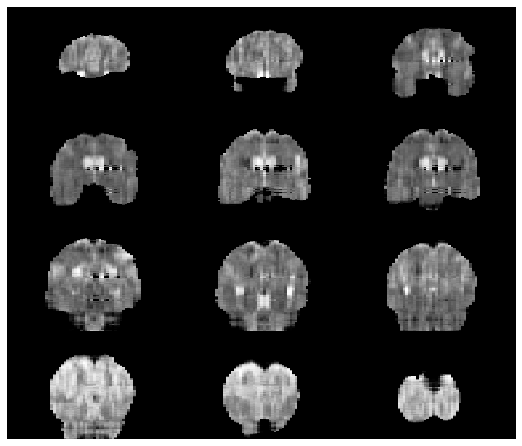

In [20]:
decoded_brain.plot(axis=1)

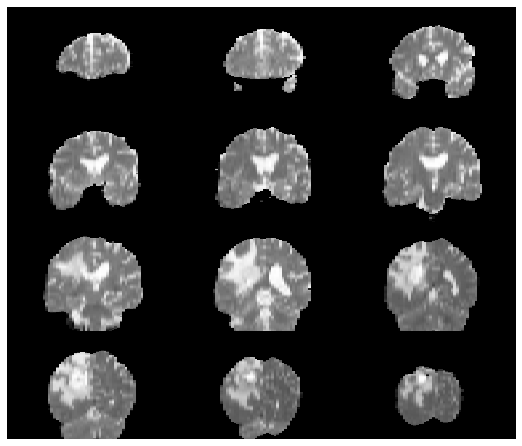

In [21]:
sample_test_brain.plot(axis=1)

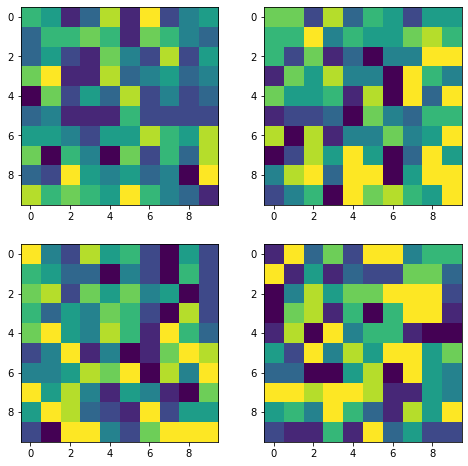

In [10]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [8]:
plt.show()

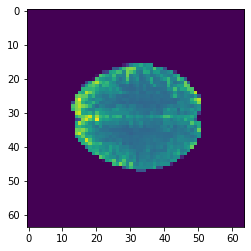

In [50]:
plt.imshow(restore_tumor[100, :, :])

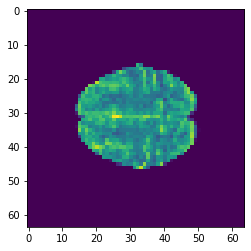

In [49]:
plt.imshow(test_tumor_tensor[100, :, :])

In [21]:
config = read_conf(f'/root/cAAE/config/config_test.json')
load_path = '/root/weights'
ans = test(config, load_path)



  0%|          | 0/35 [00:00<?, ?it/s]

[Cuda: True]




  3%|▎         | 1/35 [00:10<05:55, 10.47s/it]

  6%|▌         | 2/35 [00:20<05:41, 10.35s/it]

  9%|▊         | 3/35 [00:30<05:30, 10.34s/it]

 11%|█▏        | 4/35 [00:40<05:16, 10.21s/it]

 14%|█▍        | 5/35 [00:50<05:04, 10.15s/it]

 17%|█▋        | 6/35 [01:00<04:53, 10.12s/it]

 20%|██        | 7/35 [01:10<04:42, 10.10s/it]

 23%|██▎       | 8/35 [01:20<04:32, 10.09s/it]

 26%|██▌       | 9/35 [01:31<04:22, 10.11s/it]

 29%|██▊       | 10/35 [01:41<04:13, 10.15s/it]

 31%|███▏      | 11/35 [01:51<04:05, 10.25s/it]

 34%|███▍      | 12/35 [02:02<03:55, 10.23s/it]

 37%|███▋      | 13/35 [02:12<03:45, 10.26s/it]

 40%|████      | 14/35 [02:22<03:34, 10.21s/it]

 43%|████▎     | 15/35 [02:32<03:24, 10.21s/it]

 46%|████▌     | 16/35 [02:42<03:13, 10.17s/it]

 49%|████▊     | 17/35 [02:53<03:04, 10.26s/it]

 51%|█████▏    | 18/35 [03:03<02:53, 10.23s/it]

 54%|█████▍    | 19/35 [03:13<02:44, 10.25s/it]

 57%|█████▋    | 20/35 [03:23<02:34, 10.27s/it]

 60%|██████    | 21/35 [03:

In [32]:
print(ans[:2])
ans[2].shape

[0.542679528403001, 0.022966939955949783]


torch.Size([155, 64, 64])

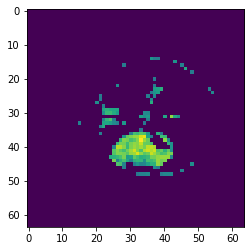

In [39]:
plt.imshow(ans[2][60, :, :])

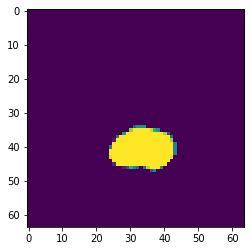

In [38]:
plt.imshow(ans[3][60, :, :])

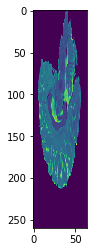

In [78]:
plt.imshow(k[0, :, 32, :])

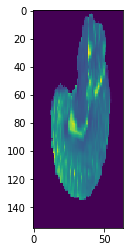

In [77]:
plt.imshow(test_brain[:, 32, :])

torch.Size([2, 260, 64, 64])

In [ ]:
config = read_conf(f'/root/cAAE/config/config_test.json')
save_path = '/root/weights'
train(config, save_path)

In [42]:
%%bash
ls /root/result/
# rm /root/result/AAE_image.png

TypeError: generator() got an unexpected keyword argument 'health_flg'